In [70]:
import openml
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np
import scipy.stats as ss
import scikit_posthocs as sp
import matplotlib.pyplot as plt

In [71]:
def run_benchmark(models, model_names, benchmark="OpenML-CC18"):
    results = pd.DataFrame(columns=["dataset", "model", "score"]) # create dataframe for results
    benchmark_suite = openml.study.get_suite(benchmark) # obtain the benchmark suite

    subset_benchmark_suite = benchmark_suite.tasks[0:10] # subset tasks

    #for task_id in benchmark_suite.tasks:  # iterate over all tasks
    for task_id in subset_benchmark_suite: # iterate over subset tasks
        task = openml.tasks.get_task(task_id)  # download the OpenML task
        features, targets = task.get_X_and_y()  # get the data
        for model in range(len(models)): # iterate over all models
            score = np.mean(cross_val_score(models[model], features, targets, cv=10, scoring="roc_auc_ovr")) # calculate the metric for kfold
            if model_names:
                results = pd.concat([results, pd.DataFrame([[task_id, model_names[model], score]], columns=results.columns)], ignore_index=True) # insert the metric for a models and a dataset
            else:
                results = pd.concat([results, pd.DataFrame([[task_id, str(models[model]), score]], columns=results.columns)], ignore_index=True) # insert the metric for a models and a dataset
    results.to_csv("results.csv", index=False)

In [72]:
KNN = make_pipeline(SimpleImputer(strategy='constant'),StandardScaler(),KNeighborsClassifier())
LR = make_pipeline(SimpleImputer(strategy='constant'),StandardScaler(),LogisticRegression())
models = [DecisionTreeClassifier(), KNN, LR]
model_names = ["DT","KNN","LR"]
run_benchmark(models=models, model_names=model_names)

/var/folders/49/9grxds_51cqc71y0q517bvx80000gn/T/ipykernel_96159/2441747011.py:5: FutureWarning: Starting from Version 0.15.0 `download_splits` will default to ``False`` instead of ``True`` and be independent from `download_data`. To disable this message until version 0.15 explicitly set `download_splits` to a bool.
  run_benchmark(models=models, model_names=model_names)
/Users/moisesrsantos/miniconda3/envs/automl/lib/python3.9/site-packages/openml/tasks/functions.py:442: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  dataset = get_dataset(task.dataset_id, *dataset_args, **get_dataset_kwargs)
/var/folders/49/9grxds_51cqc71y0q517bvx80000gn/T/ipykernel_96159/577490158.py:10: F

In [73]:
results = pd.read_csv("results.csv")
avg_rank = results.groupby('dataset').score.rank(pct=True).groupby(results.model).mean()
avg_rank

model
DT     0.366667
KNN    0.666667
LR     0.966667
Name: score, dtype: float64

In [74]:
results

,dataset,model,score
0,3,DT,0.978041
1,3,KNN,0.855901
2,3,LR,0.987016
3,6,DT,0.937218
4,6,KNN,0.996041
5,6,LR,0.980183
6,11,DT,0.661818
7,11,KNN,0.766746
8,11,LR,0.962200
9,12,DT,0.937778


In [75]:
ss.friedmanchisquare(results.loc[results["model"]=="DT",:][["score"]], results.loc[results["model"]=="LR",:][["score"]], results.loc[results["model"]=="KNN",:][["score"]])

FriedmanchisquareResult(statistic=array([16.2]), pvalue=array([0.00030354]))

(<Axes: >, <matplotlib.colorbar.Colorbar at 0x31ef46130>)

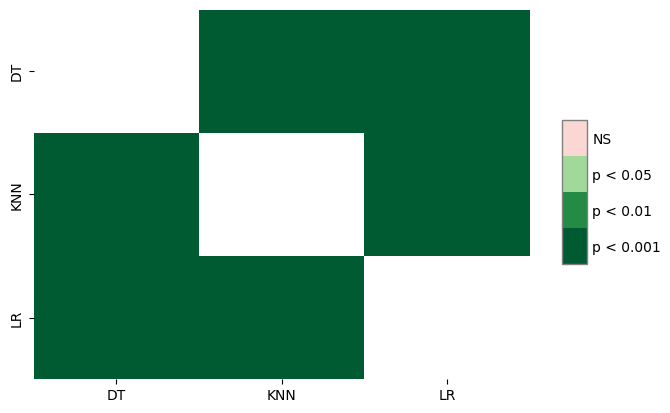

In [76]:
test_results = sp.posthoc_conover_friedman(
    results,
    melted=True,
    block_col='dataset',
    group_col='model',
    y_col='score',
)
sp.sign_plot(test_results)

/Users/moisesrsantos/miniconda3/envs/automl/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


{'markers': [<matplotlib.collections.PathCollection at 0x31ef5cc10>,
 'elbows': [<matplotlib.lines.Line2D at 0x31f819280>,
 'labels': [Text(0.35666666666666663, -1, 'DT (0.37)'),
  Text(0.35666666666666663, -2, 'KNN (0.67)'),
  Text(0.9766666666666666, -1, '(0.97) LR')],
 'crossbars': []}

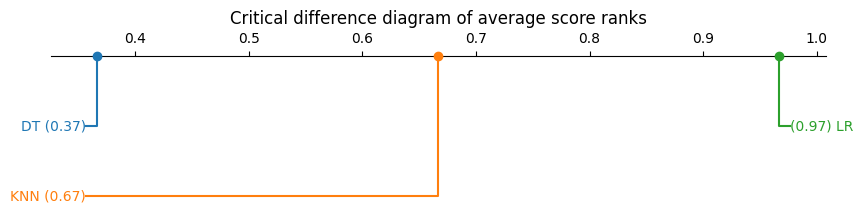

In [77]:
plt.figure(figsize=(10, 2), dpi=100)
plt.title('Critical difference diagram of average score ranks')
sp.critical_difference_diagram(avg_rank, test_results)